In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pymc3
import ktransit

%matplotlib inline

In [2]:
time = np.arange(0, 10, 0.0188)
N = len(time)

M = ktransit.LCModel()
M.add_star(
        rho=1.5, # mean stellar density in cgs units
        ld1=0.2, # ld1--4 are limb darkening coefficients 
        ld2=0.4, # if only ld1 and ld2 are non-zero then a quadratic limb darkening law is used
        ld3=0.0, # if all four parameters are non-zero we use non-linear flavour limb darkening
        ld4=0.0, 
        dil=0.0, # a dilution factor: 0.0 -> transit not diluted, 0.5 -> transit 50% diluted
        zpt=0.0  # a photometric zeropoint, incase the normalisation was wonky
        )
M.add_planet(
        T0=1.0,     # a transit mid-time  
        period=1.0, # an orbital period in days
        impact=0.1, # an impact parameter
        rprs=0.03,   # planet stellar radius ratio  
        ecosw=0.0,  # eccentricity vector
        esinw=0.0,
        occ=0.0)    # a secondary eclipse depth in ppm

M.add_data(
        time = time,                                 # timestamps to evaluate the model on
        itime = np.zeros_like(time)+0.0188 )      # integration time of each timestamp

tmod = M.transitmodel # the out of transit data will be 0.0 unless you specify zpt


true_regression_line = tmod
# add noise
y = tmod + np.random.normal(scale=1.E-4, size=N)

data = dict(x=time, y=y)


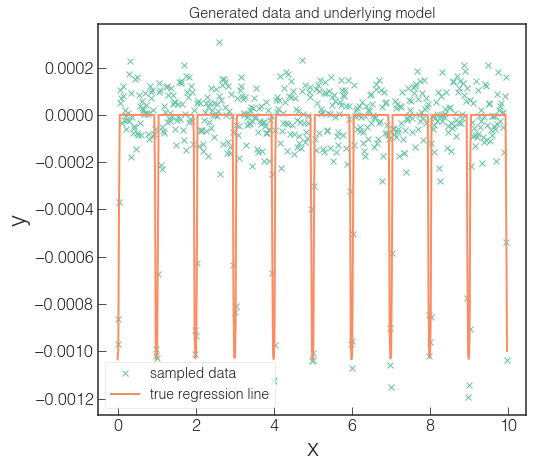

In [3]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(time, y, 'x', label='sampled data')
ax.plot(time, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

In [11]:
def get_tmod(T0,period,impact,rprs,zpt):
    M = ktransit.LCModel()
    M.add_star(
            rho=1.5, # mean stellar density in cgs units
            ld1=0.2, # ld1--4 are limb darkening coefficients 
            ld2=0.4, # if only ld1 and ld2 are non-zero then a quadratic limb darkening law is used
            ld3=0.0, # if all four parameters are non-zero we use non-linear flavour limb darkening
            ld4=0.0, 
            dil=0.0, # a dilution factor: 0.0 -> transit not diluted, 0.5 -> transit 50% diluted
            zpt=zpt  # a photometric zeropoint, incase the normalisation was wonky
            )
    M.add_planet(
            T0=T0,     # a transit mid-time  
            period=period, # an orbital period in days
            impact=impact, # an impact parameter
            rprs=rprs,   # planet stellar radius ratio  
            ecosw=0.0,  # eccentricity vector
            esinw=0.0,
            occ=0.0)    # a secondary eclipse depth in ppm

    M.add_data(
            time = time,                                 # timestamps to evaluate the model on
            itime = np.zeros_like(time)+0.0188 )      # integration time of each timestamp
    
    return M.transitmodel


with pymc3.Model() as model:
    # Define priors
    T0 = pymc3.Uniform('T0', 0.0, 2.0)
    period = pymc3.Normal('period', 1.0, 0.3)
    impact = pymc3.Uniform('impact', 0, 1)
    rprs = pymc3.Uniform('rprs', 0, 1)
    zpt = pymc3.Uniform('zpt', -1.E-5, 1.E-5)
    
    transitmodel = pymc3.Deterministic('transitmodel', get_tmod(T0,period,impact,rprs,zpt))
    
    # Define likelihood
    likelihood = pymc3.Normal('y', mu=M.transitmodel, 
                        sd=1.E-4, observed=y)
    
    # Inference!
    start = pymc3.find_MAP() # Find starting value by optimization
    step = pymc3.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pymc3.sample(10, step, start=start, progressbar=False) # draw 2000 posterior samples using NUTS sampling

ValueError: setting an array element with a sequence.

In [10]:
import pdb
pdb.pm()

> /Users/tom/.virtualenvs/p2/lib/python2.7/site-packages/ktransit/ktransit.py(66)add_planet()
-> self.T0[pnum] = T0
(Pdb) T0
T0
(Pdb) period
period
(Pdb) self.T0
array([ 0.])
(Pdb) T0.dtype
'float64'
(Pdb) T0.value
*** AttributeError: 'TransformedRV' object has no attribute 'value'
(Pdb) q


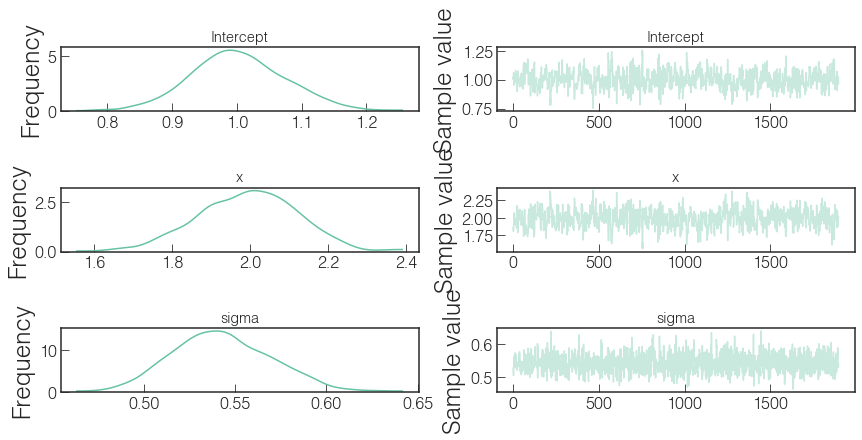

In [13]:
plt.figure(figsize=(7, 7))
pymc3.traceplot(trace[100:])
plt.tight_layout();

In [18]:
orbitsTr = (10.5/24.)*24.*60/96
print(orbitsTr)

6.5625


In [21]:
 np.ceil(orbitsTr*1.2+1)

9.0